This Python script allows user to directly change parameters of the waveform, encode motor instructions, and control the motors (via serial thorugh arduino) to perform one period of the combined waveform displacement.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import serial
from scipy.signal import find_peaks

# Variables
heart_amplitude = 0.5
heart_frequency = 80 / 60  # Hz
lung_amplitude = 0.5
lung_frequency = 15 / 60   # Hz
lead_screw_lead = 8
steps_per_revolution = 200
wave_period = 1 / lung_frequency

# Time vectors
t_fine = np.arange(0, wave_period, 0.01)

def generate_motion(t, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency):
    heart_motion = heart_amplitude * np.sin(2 * np.pi * heart_frequency * t)
    lung_motion = lung_amplitude * np.sin(2 * np.pi * lung_frequency * t)
    combined_motion = heart_motion + lung_motion
    return heart_motion, lung_motion, combined_motion

def encode_motor_instructions(steps, acceleration):
    data = ['P']  # Start byte 'P'
    mag = f'{abs(acceleration):03X}'
    data.append(mag)
    for step in steps:
        sign = '1' if step >= 0 else '0'
        magnitude = f'{abs(step):03X}'    # mag in 3 hex bytes, sign in 1 byte, total 4 bytes per datapoint
        data.append(sign)                    
        data.append(magnitude)
    data.append('V')                      # End byte 'V'
    return ''.join(data).encode('utf-8')

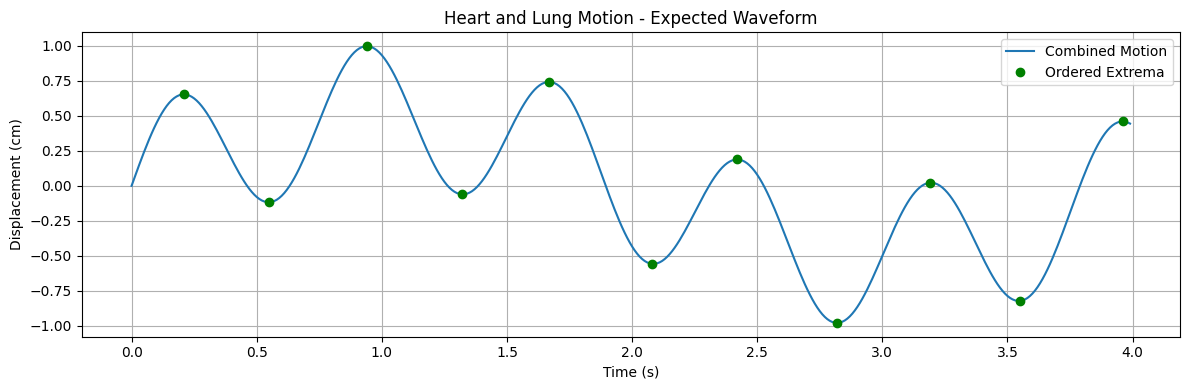

6200
Non-encoded Motor Steps: [-193  279 -265  201 -325  186 -292  250 -211  320   48]
Encoded Motor Instructions: b'P03E00C11117010910C9014510BA012410FA00D311401030V'


In [18]:
heart_motion_fine, lung_motion_fine, combined_motion_fine = generate_motion(t_fine, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)

peaks, _ = find_peaks(combined_motion_fine)
troughs, _ = find_peaks(-combined_motion_fine)

extrema_indices = np.sort(np.concatenate((peaks, troughs)))
extrema_values = combined_motion_fine[extrema_indices]
extrema_values_mm = extrema_values * 10  # in mm

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t_fine, combined_motion_fine, label='Combined Motion', linestyle='-')
plt.plot(t_fine[extrema_indices], combined_motion_fine[extrema_indices], 'go', label='Ordered Extrema')
plt.title('Heart and Lung Motion - Expected Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

displacements_mm = np.diff(extrema_values_mm)
steps_per_mm = steps_per_revolution / lead_screw_lead 
motor_steps = np.round(displacements_mm * steps_per_mm).astype(int)

# Add return step to complete iteration
return_step = -np.round((extrema_values_mm[-1] - extrema_values_mm[0]) * steps_per_mm).astype(int)
motor_steps = np.append(motor_steps, return_step)

velocity_wf = np.gradient(combined_motion_fine, t_fine)
acceleration_wf = np.gradient(velocity_wf, t_fine)

# Find the maximum acceleration
# acceleration = round(np.max(np.abs(acceleration_wf)) *100 * 2/ (8 * 8))
acceleration = 62
print(acceleration*100)
motor_instructions = encode_motor_instructions(motor_steps, acceleration)

print(f'Non-encoded Motor Steps: {motor_steps}')
print(f'Encoded Motor Instructions: {motor_instructions}')

ser = serial.Serial('COM3', 9600, timeout=1)
time.sleep(2) 
ser.flush()
ser.flushInput()
ser.write(motor_instructions)

while True:
    if ser.in_waiting > 0:
        line = ser.readline().decode('utf-8').rstrip()
        if line == "Y":
            break
        print(line)

# Close serial connection
ser.close()
print("End")

4025
End
